# Task 5
## 1. Env set up
1. ... already set up
2. pip install transformers datasets torch scikit-learn umap-learn matplotlib tqdm google-generativeai pillow tensorboard
3. using proxy to visit some webs
---
## 2. Work Sequentially
- I'm using Python 3.13, which is too new for packages like 'cuda', resulting in tasks running on CPU. And thus subtask 2 takes too long(about half an hour) too run. So I split data preparation to conveniently run subtask 4-5.
- This task is mostly based on Prompt Engineering.

### Subtask 1
#### a. deploy
1. install git lfs
2. git clone: (powershell)

        $env:GIT_LFS_SKIP_SMUDGE="1"; git clone https://huggingface.co/google/siglip2-base-patch16-224

3. cd file folder and pull lfs files

        git lfs pull 

4. Run first example code in the repo


In [1]:
from transformers import pipeline
from transformers import AutoProcessor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load pipeline
ckpt = r"C:\Users\zxy84\Documents\GitHub\AI_Pi\siglip2-base-patch16-224"
image_classifier = pipeline(model=ckpt, task="zero-shot-image-classification",device=device)
model = image_classifier.model
processor = AutoProcessor.from_pretrained(ckpt)

# load image and candidate labels
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
candidate_labels = ["2 cats", "a plane", "a remote"]

# run inference
outputs = image_classifier(url, candidate_labels)
print(outputs)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[{'score': 0.17189541459083557, 'label': '2 cats'}, {'score': 0.02414991706609726, 'label': 'a remote'}, {'score': 2.1914920580456965e-06, 'label': 'a plane'}]


5. Analysis:
- the image is a picture of 'two cats', and the model correctly classifies it with highest score.

### Subtask 2
#### a. download dataset(or use streaming)
1. git clone, cd the directory and lfs pull:(powershell, can be done at the same time with subtask 1)

        $env:GIT_LFS_SKIP_SMUDGE="1";git clone https://huggingface.co/datasets/ethz/food101
        cd .\food101
        git lfs pull

2. Actually it's too slow. Try another way:
```python

import os

os.environ["HF_DATASETS_CACHE"] = "D:/FFFFFFFiles/datasets"
from datasets import load_dataset

ds = load_dataset("ethz/food101")

```
#### b. run the code below:

In [2]:
# prepare dataset
from datasets import load_dataset
from tqdm.auto import tqdm

# Load the dataset and class names
local_dataset_path = "D:/FFFFFFFiles/datasets"
print(f"Loading dataset from local path: {local_dataset_path}")
food101_dataset = load_dataset(local_dataset_path)
class_names = food101_dataset['train'].features['label'].names
print(f"Found {len(class_names)} classes in the local food101 dataset.")

# Prepare the common validation set for Subtasks 2, 4, and 5
validation_set = food101_dataset['validation']
images_to_test = []
true_labels = []
class_counts = {i: 0 for i in range(len(class_names))}
num_target_images = 101 * 10

print(f"\nCollecting {num_target_images} images (10 from each of 101 classes) for testing...")

# Iterate through the validation set to get the required images
for example in tqdm(validation_set):
    label = example['label']
    if class_counts.get(label, 10) < 10:
        images_to_test.append(example['image'].convert("RGB"))
        true_labels.append(label)
        class_counts[label] = class_counts.get(label, 0) + 1
    
    if len(images_to_test) >= num_target_images:
        break

print(f"\nCollected {len(images_to_test)} images. This data is now ready for Subtasks 2, 4, and 5.")

Loading dataset from local path: D:/FFFFFFFiles/datasets
Found 101 classes in the local food101 dataset.



  0%|          | 0/25250 [00:00<?, ?it/s]

c:\scoop\apps\python\3.13.7\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Collected 1010 images. This data is now ready for Subtasks 2, 4, and 5.


In [3]:
from sklearn.metrics import top_k_accuracy_score
import numpy as np
from tqdm.auto import tqdm

# run inference on the collected images
outputs = image_classifier(images_to_test, candidate_labels=class_names)

# Format outputs for metric calculation
predicted_scores = []
for result in tqdm(outputs, desc="Formatting results"):
    score_array = np.zeros(len(class_names))
    score_map = {item['label']: item['score'] for item in result}
    for j, name in enumerate(class_names):
        score_array[j] = score_map.get(name, 0)
    predicted_scores.append(score_array)

predicted_scores_np = np.array(predicted_scores)
true_labels_np = np.array(true_labels)

# Calculate the top-5 accuracy
top5_accuracy = top_k_accuracy_score(true_labels_np, predicted_scores_np, k=5)

print(f"Zero-shot Top-5 Accuracy on 1010 images: {top5_accuracy:.4f}")
print(f"\nSubtask 2 Finished!")

Formatting results:   0%|          | 0/1010 [00:00<?, ?it/s]

Zero-shot Top-5 Accuracy on 1010 images: 0.9881

Subtask 2 Finished!


### Subtask 3

  0%|          | 0/75750 [00:00<?, ?it/s]

c:\scoop\apps\python\3.13.7\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Collected 500 images for Subtask 3.
Model and processor loaded successfully.



  0%|          | 0/75750 [00:00<?, ?it/s]

c:\scoop\apps\python\3.13.7\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Collected 500 images.

Generating image embeddings...


Generating Embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

Embeddings generated with shape: (500, 768)

Running UMAP for dimensionality reduction...


c:\scoop\apps\python\3.13.7\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-reduced embeddings shape: (500, 2)

Plotting results...


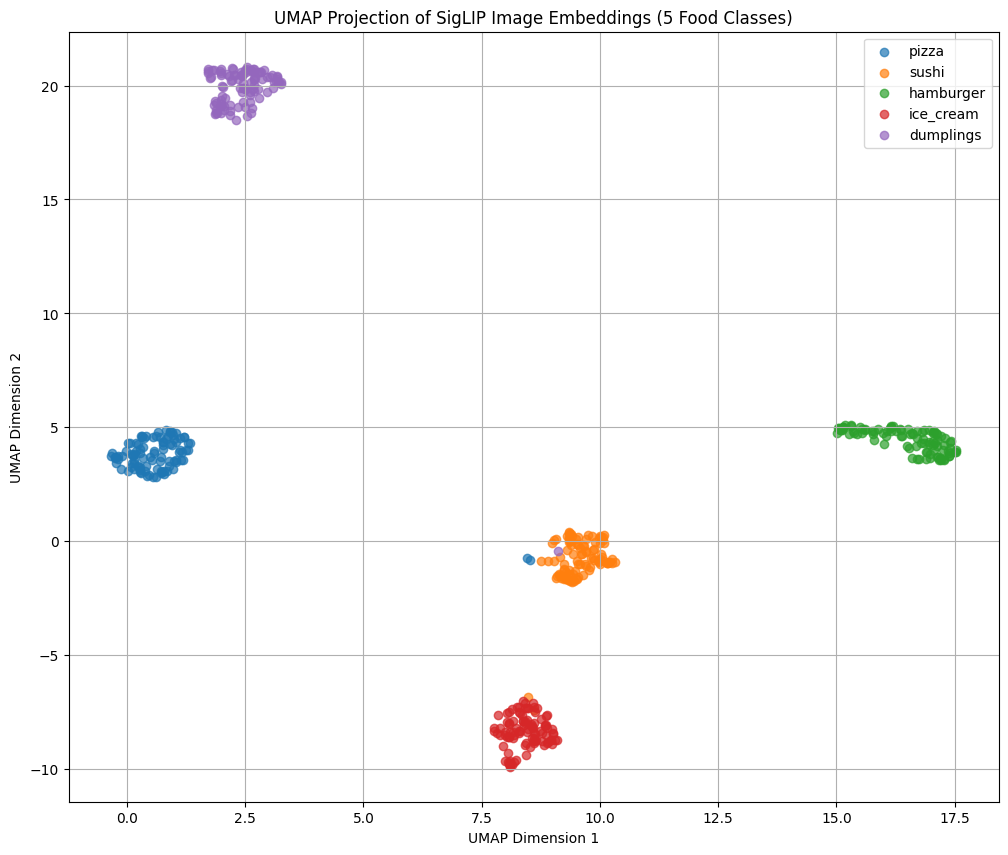

In [4]:
# Subtask 3

# prepare data
from tqdm.auto import tqdm

# Define target classes for Subtask 3
target_class_names = ['pizza', 'sushi', 'hamburger', 'ice_cream', 'dumplings']
target_class_ids = [class_names.index(name) for name in target_class_names]
id_to_name_map = {id: name for id, name in zip(target_class_ids, target_class_names)}

train_set = food101_dataset['train']
images_for_embedding = []
labels_for_embedding = []
class_counts_subset = {i: 0 for i in target_class_ids}
num_target_subset = len(target_class_names) * 100

print(f"\nCollecting {num_target_subset} images for UMAP visualization (Subtask 3)...")
for example in tqdm(train_set):
    label = example['label']
    if label in class_counts_subset and class_counts_subset[label] < 100:
        images_for_embedding.append(example['image'].convert("RGB"))
        labels_for_embedding.append(label)
        class_counts_subset[label] += 1
    
    if len(images_for_embedding) >= num_target_subset:
        break

print(f"Collected {len(images_for_embedding)} images for Subtask 3.")


# generate embeddings
import torch
from transformers import AutoProcessor, AutoModel
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import numpy as np

# reuse model and dataset
model = image_classifier.model
processor = AutoProcessor.from_pretrained(ckpt)
print("Model and processor loaded successfully.")

target_class_names = ['pizza', 'sushi', 'hamburger', 'ice_cream', 'dumplings']
target_class_ids = [class_names.index(name) for name in target_class_names]
id_to_name_map = {id: name for id, name in zip(target_class_ids, target_class_names)}

train_set = food101_dataset['train']
images_for_embedding = []
labels_for_embedding = []
class_counts_subset = {i: 0 for i in target_class_ids}
num_target_subset = len(target_class_names) * 100

print(f"\nCollecting {num_target_subset} images for UMAP visualization...")
for example in tqdm(train_set):
    label = example['label']
    if label in class_counts_subset and class_counts_subset[label] < 100:
        images_for_embedding.append(example['image'].convert("RGB"))
        labels_for_embedding.append(label)
        class_counts_subset[label] += 1
    
    if len(images_for_embedding) >= num_target_subset:
        break

print(f"Collected {len(images_for_embedding)} images.")

print("\nGenerating image embeddings...")
embeddings = []
batch_size = 32

for i in tqdm(range(0, len(images_for_embedding), batch_size), desc="Generating Embeddings"):
    batch_images = images_for_embedding[i:i+batch_size]
    inputs = processor(images=batch_images, return_tensors="pt").to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        # Move embeddings to CPU and convert to numpy
        embeddings.append(image_features.cpu().numpy())

# Combine all batch embeddings into a single numpy array
embeddings = np.vstack(embeddings)
print(f"Embeddings generated with shape: {embeddings.shape}")

# Reduce Dimensionality with UMAP
print("\nRunning UMAP for dimensionality reduction...")
# Using random_state for reproducible results
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)
print(f"UMAP-reduced embeddings shape: {embedding_2d.shape}")

# Plot the 2D Embeddings
print("\nPlotting results...")
plt.figure(figsize=(12, 10))
for class_id in target_class_ids:
    # Find the indices in our collected data that correspond to the current class
    indices = [i for i, l in enumerate(labels_for_embedding) if l == class_id]
    # Use these indices to plot the 2D points
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1], label=id_to_name_map[class_id], alpha=0.7)

plt.title("UMAP Projection of SigLIP Image Embeddings (5 Food Classes)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

### Subtask 4

  0%|          | 0/75750 [00:00<?, ?it/s]

c:\scoop\apps\python\3.13.7\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Collected 101 original training images.
Generating 9 augmentations for each of the 101 images...


  0%|          | 0/101 [00:00<?, ?it/s]

New augmented training set size: 1010 images.

Reusing 1010 validation images from Subtask 2.


Generating Embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Embeddings:   0%|          | 0/32 [00:00<?, ?it/s]


Starting training on augmented data...


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training finished.
To view loss curve, run in your terminal: tensorboard --logdir=runs

Accuracy of the linear probe on 1010 validation images (with augmentation): 68.22 %


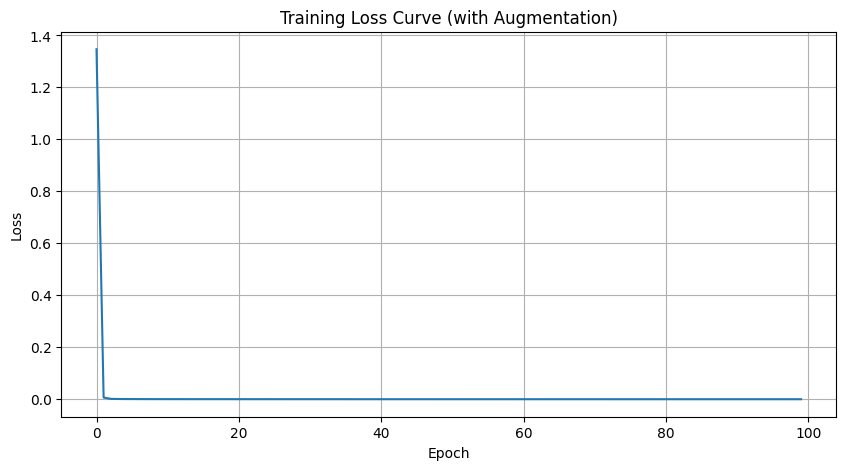


Subtask 4 Finished!


In [7]:
# Subtask 4
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt

# Initialize TensorBoard writer
writer = SummaryWriter('runs/food101_linear_probe')

# These are common augmentations that create variations of the original image.
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), # Converts to tensor, but we will convert back for the processor
    transforms.ToPILImage() # Convert back to PIL Image to be compatible with the processor
])

# Prepare Data and Generate Embeddings

# a) Training data: 1 original image per class
original_train_images = []
original_train_labels = []
seen_classes = [False] * len(class_names)
print("\nCollecting 1 original training image per class...")
for example in tqdm(food101_dataset['train']):
    label = example['label']
    if not seen_classes[label]:
        original_train_images.append(example['image'].convert("RGB"))
        original_train_labels.append(label)
        seen_classes[label] = True
    if all(seen_classes):
        break
print(f"Collected {len(original_train_images)} original training images.")

# 3. Create augmented images
num_augmentations_per_image = 9 # Create 9 new versions + 1 original = 10 total
augmented_train_images = []
augmented_train_labels = []

print(f"Generating {num_augmentations_per_image} augmentations for each of the {len(original_train_images)} images...")
for img, label in tqdm(zip(original_train_images, original_train_labels), total=len(original_train_images)):
    # Add the original image
    augmented_train_images.append(img)
    augmented_train_labels.append(label)
    # Add augmented versions
    for _ in range(num_augmentations_per_image):
        augmented_img = augmentation_transform(img)
        augmented_train_images.append(augmented_img)
        augmented_train_labels.append(label)

print(f"New augmented training set size: {len(augmented_train_images)} images.")

# --- MODIFICATION END ---

# b) Validation data: Reusing the same 1010 images from Subtask 2 for a fair comparison
print(f"\nReusing {len(images_to_test)} validation images from Subtask 2.")
val_images = images_to_test
val_labels = true_labels

# c) Generate embeddings for training and validation sets
def get_embeddings(images, batch_size=32):
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(images), batch_size), desc="Generating Embeddings"):
            batch = images[i:i+batch_size]
            inputs = processor(images=batch, return_tensors="pt").to(device)
            embeddings = model.get_image_features(**inputs)
            all_embeddings.append(embeddings.cpu())
    return torch.cat(all_embeddings)

# Use the new augmented dataset for training embeddings
train_embeddings = get_embeddings(augmented_train_images)
val_embeddings = get_embeddings(val_images)

train_labels = torch.tensor(augmented_train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

#2. Create DataLoader
train_dataset = TensorDataset(train_embeddings, train_labels)
# Batch size can be larger now
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 

val_dataset = TensorDataset(val_embeddings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32)

#3. Define the Linear Probing Model
embedding_dim = train_embeddings.shape[1]
num_classes = len(class_names)
probe_model = nn.Linear(embedding_dim, num_classes).to(device)

#4. Training
# Hyperparameters
learning_rate = 0.01 
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(probe_model.parameters(), lr=learning_rate)

print("\nStarting training on augmented data...")
loss_history = []
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    probe_model.train()
    running_loss = 0.0
    for embeddings_batch, labels_batch in train_loader:
        embeddings_batch, labels_batch = embeddings_batch.to(device), labels_batch.to(device)
        
        optimizer.zero_grad()
        outputs = probe_model(embeddings_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    # Log loss to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)

writer.close()
print("Training finished.")
print("To view loss curve, run in your terminal: tensorboard --logdir=runs")

#5. Evaluation
probe_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for embeddings_batch, labels_batch in val_loader:
        embeddings_batch, labels_batch = embeddings_batch.to(device), labels_batch.to(device)
        outputs = probe_model(embeddings_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

accuracy = 100 * correct / total
print(f'\nAccuracy of the linear probe on {total} validation images (with augmentation): {accuracy:.2f} %')

#6. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_history)
plt.title("Training Loss Curve (with Augmentation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("\nSubtask 4 Finished!")

### Subtask 5
- designed 2 prompts, but the maybe better one is not tested due to api unavailability.
- to test it, run the first 2 python cells(which requires local dataset) and run this cell.
- wrote a cleaning function to parse the output, but not very effective.

In [ ]:
import os
import asyncio
import base64
import io
import openai
from openai import AsyncOpenAI
from PIL import Image
from tqdm.asyncio import tqdm_asyncio
from sklearn.metrics import accuracy_score
import numpy as np

# --- 0. Setup API Client and Environment ---
# Using the API configuration from the task description
print("Setting up Gemini API client...")
os.environ["OPENAI_API_KEY"] = "sk-yxhm7vIgkeffD0FU1bE5F797B654482d94CbB6DbBa556b96"
os.environ["OPENAI_BASE_URL"] = "https://api.ai-gaochao.cn/v1"

client = AsyncOpenAI()

# --- 1. Prepare Data and Prompt ---
# Reusing variables from Subtask 2
# images_to_test: A list of 1010 PIL Image objects
# true_labels: A list of 1010 integer labels
# class_names: A list of 101 string class names

# Helper function to convert PIL image to base64
def pil_to_base64(image: Image.Image, format="jpeg") -> str:
    buffer = io.BytesIO()
    image.save(buffer, format=format)
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

# Create a string of all possible class names for the prompt
class_list_str = ", ".join(class_names)

# Define the prompt template
# This prompt guides the model to return only the class name for easy parsing.
PROMPT_TEMPLATE = f"""
Identify the food in this image. Choose your answer from the following list of 101 food classes.
Respond with only the single, most likely class name and nothing else.

Classes: {class_list_str}
"""

print(f"Data and prompt prepared. Will classify {len(images_to_test)} images.")


# A (maybe) better prompt, but no chance to test for the api is unavailable.
# This prompt guides the model to return only the class name for easy parsing.
PROMPT_TEMPLATE_1 = f"""
You are an expert food classifier. Your task is to identify the food in the image and respond with ONLY the corresponding class name from the provided list. Do not add any extra text, explanations, or punctuation.

Here are some examples of correct responses:
- If you see a picture of a hamburger, you should respond with: hamburger
- If you see a picture of sushi, you should respond with: sushi

Now, identify the food in the following image.

List of possible classes: {class_list_str}

Your answer:
"""

print(f"Data and prompt prepared. Will classify {len(images_to_test)} images.")


# --- 2. Define Asynchronous API Call Function ---
# MODIFICATION: Added a 'semaphore' argument
async def classify_image_with_gemini(image: Image.Image, session_client: AsyncOpenAI, semaphore: asyncio.Semaphore):
    # MODIFICATION: Acquire the semaphore before making the API call
    async with semaphore:
        base64_image = pil_to_base64(image)
        
        try:
            response = await session_client.chat.completions.create(
                model="gemini-2.5-flash", # As specified in the task
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": PROMPT_TEMPLATE},
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                            },
                        ],
                    }
                ],
                max_tokens=50, # A class name is short, so we don't need many tokens
                temperature=0.0, # Set to 0 for deterministic, most likely output
            )
            # Extract the text and clean up any extra whitespace or quotes
            return response.choices[0].message.content.strip().strip('"')
        except Exception as e:
            # If an API call fails, return an error string
            return f"API_ERROR: {str(e)}"





# --- 3. Run Asynchronous Classification ---
async def run_classification():
    print("\nStarting classification with Gemini 2.5 Flash...")
    # MODIFICATION: Create a semaphore to limit concurrency to 50
    concurrency_limit = 50
    semaphore = asyncio.Semaphore(concurrency_limit)
    
    # MODIFICATION: Pass the semaphore to each task
    tasks = [classify_image_with_gemini(img, client, semaphore) for img in images_to_test]
    
    # tqdm_asyncio shows a progress bar for our async tasks
    predictions = await tqdm_asyncio.gather(*tasks)
    return predictions

# Run the main async function
# Note: This will make 1010 API calls and may take several minutes and incur costs.
gemini_predictions_str = await run_classification()
print("All API calls completed.")

# --- 4. Calculate Accuracy and Compare ---
# Convert predicted string labels to integer IDs
# Create a mapping from class name string to integer ID
name_to_id_map = {name: i for i, name in enumerate(class_names)}

predicted_labels = []
api_errors = 0
invalid_responses = 0
for pred_str in gemini_predictions_str:
    if "API_ERROR" in pred_str:
        api_errors += 1
        predicted_labels.append(-1) # Mark as incorrect
        continue

    # Clean the model's output string
    # 1. Convert to lowercase
    # 2. Replace spaces and hyphens with underscores
    # 3. Remove common punctuation and extra words
    cleaned_str = pred_str.lower().replace(' ', '_').replace('-', '_')
    
    # Find the best matching class name in the cleaned string
    found_match = False
    for class_name in class_names:
        if class_name in cleaned_str:
            predicted_labels.append(name_to_id_map[class_name])
            found_match = True
            break # Stop after finding the first match
    
    if not found_match:
        invalid_responses += 1
        predicted_labels.append(-1) # Mark as incorrect if no class name is found
# --- MODIFICATION END ---

# Ensure lists are numpy arrays for metric calculation
true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Calculate Top-1 Accuracy
gemini_accuracy = accuracy_score(true_labels_np, predicted_labels_np)

print("\n--- Subtask 5 Results ---")
print(f"Total images processed: {len(images_to_test)}")
print(f"Successful API calls: {len(images_to_test) - api_errors}")
print(f"API errors: {api_errors}")
print(f"Invalid/unrecognized responses: {invalid_responses}")
print(f"\nGemini 2.5 Flash Top-1 Accuracy: {gemini_accuracy:.4f}")

if 'top5_accuracy' in locals() or 'top5_accuracy' in globals():
    print(f"For comparison, SigLIP Zero-Shot Top-5 Accuracy (from Subtask 2): {top5_accuracy:.4f}")
else:
    print("\n(SigLIP Zero-Shot Top-5 Accuracy from Subtask 2 was not calculated in this session.)")
    
print("\nSubtask 5 Finished!")

Setting up Gemini API client...
Data and prompt prepared. Will classify 1010 images.

Starting classification with Gemini 2.5 Flash...


100%|██████████| 1010/1010 [01:25<00:00, 11.76it/s]

All API calls completed.

--- Subtask 5 Results ---
Total images processed: 1010
Successful API calls: 1010
API errors: 0
Invalid/unrecognized responses: 924

Gemini 2.5 Flash Top-1 Accuracy: 0.0782
For comparison, SigLIP Zero-Shot Top-5 Accuracy (from Subtask 2): 0.9881

Subtask 5 Finished!
